file successfully read



first 5 rows of the dataset:



  Transaction ID    Item Quantity Price Per Unit Total Spent  Payment Method  Location Transaction Date
0    TXN_1961373  Coffee        2            2.0         4.0     Credit Card  Takeaway       2023-09-08
1    TXN_4977031    Cake        4            3.0        12.0            Cash  In-store       2023-05-16
2    TXN_4271903  Cookie        4            1.0       ERROR     Credit Card  In-store       2023-07-19
3    TXN_7034554   Salad        2            5.0        10.0         UNKNOWN   UNKNOWN       2023-04-27
4    TXN_3160411  Coffee        2            2.0         4.0  Digital Wallet  In-store       2023-06-11



info and description of the dataset:



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    10000 non-null  object
 1   Item              9667 no

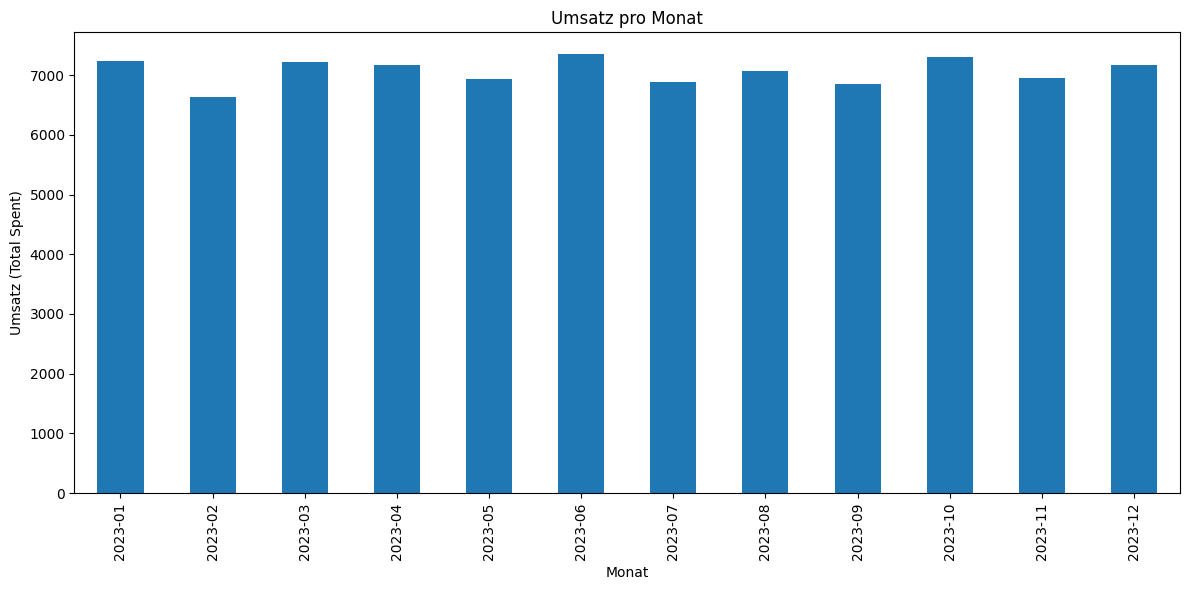






So, this is what we did:




Cleaning Report:
Price Per Unit fixed/filled: 495
Total Spent fixed/filled: 462
Quantity fixed/filled: 441
Item fixed/filled: 1337
Payment Method fixed/filled: 3178
Location fixed/filled: 3961
Transaction Date fixed/filled: 159
Invalid rows (plausibility check failed): 18

We have 2 new files saved as:
 - clean_cafe_sales.csv (cleaned data)
 - transactions_invalid.csv (invalid rows)





Let's check the cleaned data. Here are 100 random rows from the cleaned dataset:



     Transaction ID          Item  Quantity  Price Per Unit  Total Spent  Payment Method  Location Transaction Date YearMonth  Check_Total_OK
7895    TXN_8035512           Tea       3.0             1.5          4.5            Cash   Unknown       2023-10-29   2023-10            True
6761    TXN_6646382           Tea       4.0             1.5          6.0         Unknown   Unknown       2023-09-16   2023-09            True
5298    TXN_5614488      Sandwich       1.0             4.0      

In [ ]:
import pandas as pd

# show 100 rows when printing a dataframe
pd.set_option('display.max_rows', 100)

# show all columns when printing a dataframe
pd.set_option('display.max_columns', None)

# do not truncate column content
pd.set_option('display.expand_frame_repr', False)

# reading the csv file
try:
    df = pd.read_csv("../data/dirty_cafe_sales.csv")
    print("file successfully read")
except FileNotFoundError:
    print("Error: file 'dirty_cafe_sales.csv' not found.")
    df = None
except pd.errors.EmptyDataError:
    print("Error: file is empty.")
    df = None
except pd.errors.ParserError:
    print("Error: file could not be read (parse error).")
    df = None
except Exception as e:
    print(f"Un unknown error occured: {e}")
    df = None

# getting some information and the first 5 rows
print("\n\n")
print("first 5 rows of the dataset:")
print("\n\n")
print(df.head())
print("\n\n")
print("info and description of the dataset:")
print("\n\n")
print(df.info())
print("\n\n")
print(df.describe())

# diving more into the csv
print("\n\n\n\n")
print("Ok, we need more information, here are random 100 rows from the dataset:")
print("\n\n")
print(df.sample(100))

# counting missing values in each column
missing_values_count = df.isnull().sum()

# printing the count of missing values
print("\n\n\n\n")
print("Count of missing values in each column:")
print("\n\n")
print(missing_values_count)

# returns all rows with at least one NaN value
print("\n\n\n\n")
print("Here you see all rows with at least one missing value:")
print("\n\n")
print(df[df.isna().any(axis=1)])

# Convert numeric columns to float
num_cols = ["Quantity", "Price Per Unit", "Total Spent"]
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Replace NaN in numeric columns with 0.0
num_cols = ["Quantity", "Price Per Unit", "Total Spent"]
df[num_cols] = df[num_cols].fillna(0.0)

# Prepare counters for reporting
fixes = {"Price Per Unit": 0, "Total Spent": 0, "Quantity": 0, 
         "Item": 0, "Payment Method": 0, "Location": 0, "Transaction Date": 0}

# Recalculate missing Price Per Unit
mask_price_missing = (df["Price Per Unit"] == 0.0) & (df["Total Spent"] > 0) & (df["Quantity"] > 0)
fixes["Price Per Unit"] = mask_price_missing.sum()
df.loc[mask_price_missing, "Price Per Unit"] = df["Total Spent"] / df["Quantity"]

# Recalculate missing Total Spent
mask_total_missing = (df["Total Spent"] == 0.0) & (df["Price Per Unit"] > 0) & (df["Quantity"] > 0)
fixes["Total Spent"] = mask_total_missing.sum()
df.loc[mask_total_missing, "Total Spent"] = df["Price Per Unit"] * df["Quantity"]

# Recalculate missing Quantity
mask_quantity_missing = (df["Quantity"] == 0.0) & (df["Price Per Unit"] > 0) & (df["Total Spent"] > 0)
fixes["Quantity"] = mask_quantity_missing.sum()
df.loc[mask_quantity_missing, "Quantity"] = df["Total Spent"] / df["Price Per Unit"]

# Clean Item values
before_items = df["Item"].isin(["ERROR", "UNKNOWN"]).sum() + df["Item"].isna().sum()

df["Item"] = df["Item"].replace(["ERROR", "UNKNOWN"], pd.NA).fillna("Unknown Item")

n_salad = ((df["Price Per Unit"] == 5) & (df["Item"].str.lower() == "unknown item")).sum()
n_coffee = ((df["Price Per Unit"] == 2) & (df["Item"].str.lower() == "unknown item")).sum()
n_tea = ((df["Price Per Unit"] == 1.5) & (df["Item"].str.lower() == "unknown item")).sum()

df.loc[(df["Price Per Unit"] == 5) & (df["Item"].str.lower() == "unknown item"), "Item"] = "Salad"
df.loc[(df["Price Per Unit"] == 2) & (df["Item"].str.lower() == "unknown item"), "Item"] = "Coffee"
df.loc[(df["Price Per Unit"] == 1.5) & (df["Item"].str.lower() == "unknown item"), "Item"] = "Tea"

fixes["Item"] = before_items + n_salad + n_coffee + n_tea

# Clean Payment Method values
before_payment = df["Payment Method"].isin(["ERROR", "UNKNOWN"]).sum() + df["Payment Method"].isna().sum()
fixes["Payment Method"] = before_payment
df["Payment Method"] = df["Payment Method"].replace(["ERROR", "UNKNOWN"], pd.NA).fillna("Unknown")

# Clean Location values
before_location = df["Location"].isin(["ERROR", "UNKNOWN"]).sum() + df["Location"].isna().sum()
fixes["Location"] = before_location
df["Location"] = df["Location"].replace(["ERROR", "UNKNOWN"], pd.NA).fillna("Unknown")

# Clean Transaction Date values
before_date = df["Transaction Date"].isna().sum()
fixes["Transaction Date"] = before_date
df["Transaction Date"] = df["Transaction Date"].replace(["ERROR", "UNKNOWN"], pd.NA)
df["Transaction Date"] = pd.to_datetime(df["Transaction Date"], errors="coerce")

# Sort by Transaction Date (NaT will be sorted last)
df_sorted = df.sort_values(by="Transaction Date")
df = df_sorted

# Plausibility check
df["Check_Total_OK"] = (df["Quantity"] * df["Price Per Unit"]).round(2) == df["Total Spent"].round(2)
invalid_rows = df[~df["Check_Total_OK"]]
invalid_count = len(invalid_rows)

# Save cleaned and invalid rows
df.to_csv("clean_cafe_sales.csv", index=False)
invalid_rows.to_csv("transactions_invalid.csv", index=False)

# Print cleaning report
print("\n\n\n\n")
print("So, this is what we did:")
print("\n\n")
print("\nCleaning Report:")
for key, val in fixes.items():
    print(f"{key} fixed/filled: {val}")
print(f"Invalid rows (plausibility check failed): {invalid_count}")
print("\nWe have 2 new files saved as:")
print(" - clean_cafe_sales.csv (cleaned data)")
print(" - transactions_invalid.csv (invalid rows)")

# data inspection
print("\n\n\n\n")
print("Let's check the cleaned data. Here are 100 random rows from the cleaned dataset:")
print("\n\n")
df2 = pd.read_csv("clean_cafe_sales.csv")
print(df2.sample(100))
print("\n\n")
print("...and now let's check if they are sorted by date:")
print(df2.head(100))
print("\n\n")
print("...and some of the last rows in order to see until when the sales are recorded:")
print(df2.iloc[9450:9461])